# Reading datasets forming a new one

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import poisson
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

directory = 'C:/Users/99451/Desktop/MODEL/eng_prem'

dfs = []

# Define the columns you want to extract from each CSV file
columns_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'B365H', 'B365D', 'B365A']

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(directory, filename), on_bad_lines = 'skip', encoding='latin-1')
        df = df[columns_to_keep]
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
df.head()

Number of rows: 8214
Number of columns: 9


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A
0,17/08/2002,Blackburn,Sunderland,0.0,0.0,D,1.727,3.25,4.333
1,17/08/2002,Charlton,Chelsea,2.0,3.0,A,2.800,3.25,2.200
2,17/08/2002,Everton,Tottenham,2.0,2.0,D,2.250,3.25,2.750
3,17/08/2002,Fulham,Bolton,4.0,1.0,H,1.727,3.25,4.333
4,17/08/2002,Leeds,Man City,3.0,0.0,H,1.667,3.40,4.500


# Adding Moving Averages

In [2]:
#Calculating Points Per Game for Home and Away Teams
df['HPTS'] = np.select([df['FTR'] == 'H', df['FTR'] == 'D', df['FTR'] == 'A'], [3, 1, 0], default=0)
df['APTS'] = np.select([df['FTR'] == 'H', df['FTR'] == 'D', df['FTR'] == 'A'], [0, 1, 3], default=0)

df['HPPG'] = df.groupby('HomeTeam')['HPTS'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['APPG'] = df.groupby('AwayTeam')['APTS'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

#Calculating scored and conceded goals
df['FTHGS'] = df.groupby('HomeTeam')['FTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['FTHGC'] = df.groupby('HomeTeam')['FTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['FTAGS'] = df.groupby('AwayTeam')['FTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['FTAGC'] = df.groupby('AwayTeam')['FTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

#Calculating odds probabilities
total = 1 / df['B365H'] + 1 / df['B365D'] + 1 / df['B365A']

df['FTH'] = (1 / df['B365H']) / total
df['FTD'] = (1 / df['B365D']) / total
df['FTA'] = (1 / df['B365A']) / total
df['FTDA'] = df['FTD'] + df['FTA']

# Calculate the league-wide moving average for home_goals and away_goals
df['league_home_goals'] = df['FTHG'].rolling(50, min_periods=1).mean().shift(1)
df['league_away_goals'] = df['FTAG'].rolling(50, min_periods=1).mean().shift(1)

#Calculating Poisson Statistics
df['home_attack'] = df['FTHGS'] / df['league_home_goals']
df['home_defence'] = df['FTHGC'] / df['league_away_goals']
df['away_attack'] = df['FTAGS'] / df['league_away_goals']
df['away_defence'] = df['FTAGC'] / df['league_home_goals']

df['home_xg'] = df['home_attack'] * df['away_defence'] * df['league_home_goals']
df['away_xg'] = df['away_attack'] * df['home_defence'] * df['league_away_goals']
df['xg_dif'] = df['home_xg'] - df['away_xg']

df.dropna(inplace = True)

df['home_poisson'] = df['home_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['away_poisson'] = df['away_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['poisson_df'] = df['home_poisson'] - df['away_poisson']
df['FTRT'] = [1 if x == 'H' else 0 for x in df['FTR']]

#Removing unnessary columns
df.drop(['Date', 'FTHG', 'FTAG', 'B365H', 'B365D', 'B365A', 'HPTS', 'APTS', 'FTHGS', 'FTHGC', 'FTAGS', 'FTAGC',
            'FTD', 'FTA', 'league_home_goals', 'league_away_goals', 'home_attack', 'home_defence',
            'away_attack', 'away_defence', 'home_xg', 'away_xg', 'xg_dif', 'FTR'], axis = 1, inplace = True)

df[df['HomeTeam'] == 'Everton'].head(7)

,HomeTeam,AwayTeam,HPPG,APPG,FTH,FTDA,home_poisson,away_poisson,poisson_df,FTRT
24,Everton,Birmingham,1.000000,0.000000,0.536974,0.463026,2,0,2,0
51,Everton,Middlesbrough,1.000000,0.500000,0.389014,0.610986,0,0,0,1
72,Everton,Fulham,1.666667,1.333333,0.398329,0.601671,1,2,-1,1
89,Everton,Arsenal,2.000000,2.000000,0.162360,0.837640,1,2,-1,1
123,Everton,Charlton,2.200000,0.800000,0.537421,0.462579,1,0,1,1
141,Everton,West Brom,2.600000,0.800000,0.622124,0.377876,1,0,1,1
162,Everton,Chelsea,3.000000,1.200000,0.359551,0.640449,0,0,0,0


# Trying with Random Forest

c:\Users\99451\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\99451\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\99451\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set


Random Forest - Training Accuracy: 0.7387235348266339
Random Forest - Test Accuracy: 0.652760736196319


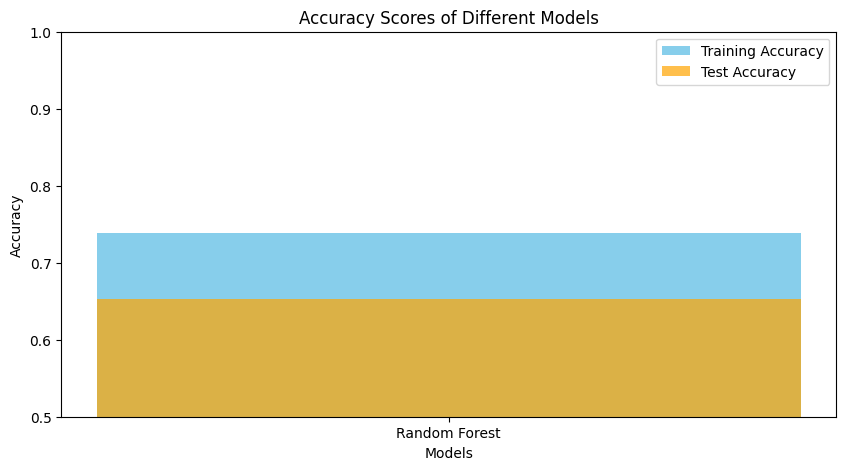

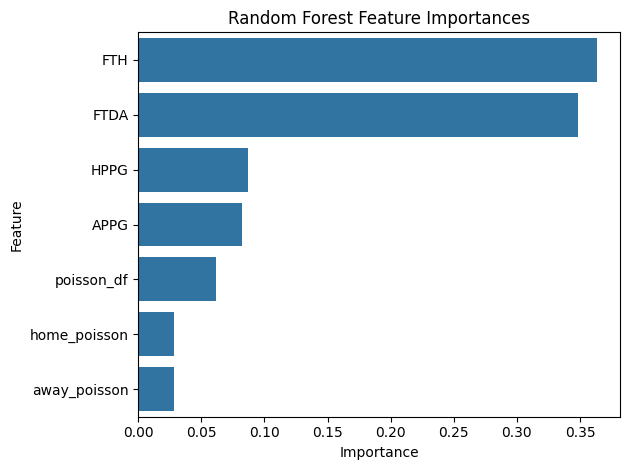

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       861
           1       0.63      0.64      0.63       769

    accuracy                           0.65      1630
   macro avg       0.65      0.65      0.65      1630
weighted avg       0.65      0.65      0.65      1630

Confusion Matrix:
[[574 287]
 [279 490]]
ROC AUC Score: 0.6519289120069356


7

In [3]:
# Split the data into training and testing sets
X = df.drop(columns=['HomeTeam', 'AwayTeam', 'FTRT'], axis = 1)  # Features
y = df['FTRT']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Random Forest
rf_model = BalancedRandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10, min_samples_leaf=10, random_state=42)

# Train models
rf_model.fit(X_train, y_train)

# Predictions
rf_train_preds = rf_model.predict(X_train)
rf_test_preds = rf_model.predict(X_test)

# Accuracy scores
rf_train_accuracy = accuracy_score(y_train, rf_train_preds)
rf_test_accuracy = accuracy_score(y_test, rf_test_preds)

print("\nRandom Forest - Training Accuracy:", rf_train_accuracy)
print("Random Forest - Test Accuracy:", rf_test_accuracy)

rf_feature_importances = rf_model.feature_importances_

# Visualize accuracy scores
models = ['Random Forest']
train_accuracies = [rf_train_accuracy]
test_accuracies = [rf_test_accuracy]

plt.figure(figsize=(10, 5))
plt.bar(models, train_accuracies, color='skyblue', label='Training Accuracy')
plt.bar(models, test_accuracies, color='orange', alpha=0.7, label='Test Accuracy')
plt.title('Accuracy Scores of Different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1)
plt.legend()
plt.show()

# Visualize feature importances
rf_feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_feature_importances})

sns.barplot(x='Importance', y='Feature', data=rf_feature_importances_df.sort_values(by='Importance', ascending=False))
plt.title('Random Forest Feature Importances')

plt.tight_layout()
plt.show()

# Print classification report
print(classification_report(y_test, rf_test_preds))

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(y_test, rf_test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, rf_test_preds)
print("ROC AUC Score:", roc_auc)

len(rf_feature_importances_df)